# SMYLE & CLM5-TRENDY TWS perfect prediction skill
- SMYLE global maps code updated for CLM output 
- Here comparing SMYLE TWS with TRENDY initial condions 
- Will Wieder, Oct 9, 2021

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from distributed import wait

%matplotlib inline

from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import io_utils as io

## Data I/O using Dask

### Create Dask Cluster

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        project='P93300041',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.1.2:37522,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in CLM monthly data; Convert to Seasonal averages (DJF, MAM, JJA, SON)
- Chosen field is returned as a dask array with leading dimensions of Y (initialization year), M (ensemble member), and L (lead season). For example, for November starts, L=1 corresponds to first DJF season.
- "time" which gives prediction verification time (centered time for a given season) is also dimensioned with (Y,L)

In [5]:
# This preprocessor will return a seasonal mean field
def preprocessor(ds0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for a your analysis to speed up processing. 
    """
    ds0 = cal.time_set_mid(ds0,'time')
    d0 = ds0[field].isel(time=slice(1, nlead))
    d0 = d0.assign_coords({"lon":ds0.lon, "lat":ds0.lat})
    d0 = cal.mon_to_seas(d0)
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.to_dataset(name=field)
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    return d0

In [6]:
# SMYLE-NOV TWS data
# process all 20 ensemble members, all start dates dates from 1970-2018:
# these only need to be defined once, with io for each initialized month handled below
field = 'TWS'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.clm2.h0.'
filetemplate = datadir+casename+'/lnd/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
print(filetemplate)
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018

/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.????-MM.EEE/lnd/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.????-MM.EEE.clm2.h0.TWS.*.nc


In [7]:
%%time
startmonth = 11
smyle11 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle11 data set = '+str(smyle11.nbytes/1e9)+ ' GB') #GB

smyle11 data set = 3.468170792 GB
CPU times: user 47.4 s, sys: 23.9 s, total: 1min 11s
Wall time: 1min 38s


In [8]:
%%time
# why not persist here (but persist also breaks the code...)?  
smyle11 = smyle11.load()
_ = wait(smyle11)

CPU times: user 1min 1s, sys: 7.83 s, total: 1min 9s
Wall time: 1min 9s


In [9]:
%%time
# SMYLE-FEB TS data
# process all 20 ensemble members, Feb dates from 1970-2018:
startmonth = 2
smyle02 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle02 data set = '+str(smyle02.nbytes/1e9)+ ' GB') #GB

smyle02 data set = 3.468170792 GB
CPU times: user 48.7 s, sys: 24.2 s, total: 1min 12s
Wall time: 1min 45s


In [10]:
%%time
smyle02=smyle02.load()
_ = wait(smyle02)

CPU times: user 1min 4s, sys: 8.69 s, total: 1min 13s
Wall time: 1min 13s


In [11]:
%%time
# SMYLE-MAY TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 5
smyle05 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('data set = '+str(smyle05.nbytes/1e9)+ ' GB') #GB

data set = 3.468170792 GB
CPU times: user 49.9 s, sys: 24 s, total: 1min 13s
Wall time: 1min 43s


In [12]:
%%time 
smyle05 = smyle05.load() 
_ = wait(smyle05)

CPU times: user 1min 6s, sys: 8.54 s, total: 1min 15s
Wall time: 1min 14s


In [13]:
%%time
# SMYLE-AUG TS data
# process all 20 ensemble members, all start dates from 1970-2018:
startmonth = 8
smyle08 = io.get_monthly_data(filetemplate,filetype,ens,nlead,field,firstyear,lastyear,startmonth,preprocessor)
print('smyle08 data set = '+str(smyle08.nbytes/1e9)+ ' GB') #GB

smyle08 data set = 3.468170792 GB
CPU times: user 50.7 s, sys: 25.2 s, total: 1min 15s
Wall time: 1min 45s


In [14]:
%%time
smyle08=smyle08.load()
_ = wait(smyle08)

CPU times: user 1min 7s, sys: 8.07 s, total: 1min 15s
Wall time: 1min 15s


### DataArrays are manageable size now (and in memory), so release Dask cluster 

### Get results from CLM5 SMYLE-TRENDY for potential predictability
/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/

In [15]:
obs_dir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/CLM5_SMYLE-Trendy/proc/tseries/month_1/'
fin = 'smyle_Transient.clm2.h0.'+field+'.185001-201812.nc'
#ds_clm = time_set_mid(xr.open_dataset(obs_dir+fin,decode_times=True),'time')
ds_clm = xr.open_dataset(obs_dir+fin,decode_times=False)
clm_montime_vals = [cftime.DatetimeNoLeap(1850+year, 1+month, 15) for year in range(169) for month in range(12)]
ds_clm['time'] = clm_montime_vals
ds_clm = ds_clm.sel(time=slice('1960','2018'))
ds_clm['time']

<xarray.DataArray 'time' (time: 708)>
array([cftime.DatetimeNoLeap(1960, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1960, 3, 15, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2018, 10, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 11, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2018, 12, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1960-01-15 00:00:00 ... 2018-12-15 00:00:00

In [16]:
# read SST data in just to make sure functions work as expected
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))

### Compute OBS seasonal averages

In [17]:
def obs_convert_mon_to_seas(da,field):
    """ Given a monthly xarray DataArray, convert to 
    seasonal averages and introduce a separate season dimension."""
    season = xr.DataArray(['DJF','MAM','JJA','SON'],dims='season',name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1,4,7,10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist,dim=season)
    return da_seas

In [19]:
hadisst_ts_seas = obs_convert_mon_to_seas(ds_hadisst.sst,'TS')

In [20]:
clm_seas = obs_convert_mon_to_seas(ds_clm.TWS,'TWS')

In [21]:
## convert OBS to anomalies from 1972-2017
clm_seas = clm_seas - clm_seas.sel(year=slice(1972,2018)).mean('year')


# Anomaly Correlation Plots

In [22]:
# Compute de-drifted anomalies from 1972-2017 climatology
smyle11_anom,smyle11_clim = stat.remove_drift(smyle11,smyle11.time,1972,2018)
smyle02_anom,smyle02_clim = stat.remove_drift(smyle02,smyle02.time,1972,2018)
smyle05_anom,smyle05_clim = stat.remove_drift(smyle05,smyle05.time,1972,2018)
smyle08_anom,smyle08_clim = stat.remove_drift(smyle08,smyle08.time,1972,2018)

In [23]:
# Skill Score Functions
import xskillscore as xs

def detrend_linear(dat, dim):
    """ linear detrend dat along the axis dim """
    params = dat.polyfit(dim=dim, deg=1)
    fit = xr.polyval(dat[dim], params.polyfit_coefficients)
    dat = dat-fit
    return dat

def leadtime_corr_byseas(mod_da,mod_time,obs_da,detrend=False):
    """ 
    Computes the correlation coefficient between two xarray DataArrays, which 
    must share the same lat/lon coordinates (if any). Assumes time coordinates are roughly compatible
    between model and obs.
    
        Inputs
        mod_da: a seasonally-averaged hindcast DataArray dimensioned (Y,L,M,...)
        obs_da: an OBS DataArray dimensioned (time,...)
        mod_time: a hindcast time DataArray dimensioned (Y,L). NOTE: assumes mod_time.dt.month
            returns mid-month of 3-month seasonal average (e.g., mon=1 ==> "DJF").
    """
    ens = mod_da.mean('M')
    seasons = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
    r_list = []
    p_list = []
    for i in ens.L.values:
        ens_ts = ens.sel(L=i).rename({'Y':'time'})
        ens_time_year = mod_time.sel(L=i).dt.year.data
        ens_time_month = mod_time.sel(L=i).dt.month.data[0]
        obs_ts = obs_da.sel(season=seasons[ens_time_month]).rename({'year':'time'})
        ens_ts = ens_ts.assign_coords(time=("time",ens_time_year))
        a,b = xr.align(ens_ts,obs_ts)
        if detrend:
                a = detrend_linear(a,'time')
                b = detrend_linear(b,'time')
        r = xs.pearson_r(a,b,dim='time')
        p = xs.pearson_r_eff_p_value(a,b,dim='time')
        r_list.append(r)
        p_list.append(p)
    corr = xr.concat(r_list,ens.L)
    pval = xr.concat(p_list,ens.L)
    return xr.Dataset({'corr':corr,'pval':pval})

In [46]:
#smyle05.time
smyle11.isel(Y=slice(0,-2)).time

<xarray.DataArray 'time' (Y: 47, L: 8)>
array([[cftime.DatetimeNoLeap(1971, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1971, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1971, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1971, 10, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 10, 16, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1972, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1972, 10, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 10, 16, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(1973, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(1973, 10, 16, 0, 0, 0, 0, has_year_zero=True),
...
        cftime.DatetimeNoLeap(2016, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 10, 16, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2016, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2016, 10, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 10, 16, 0, 0, 0, 0, has_year_zero=True)],
       [cftime.DatetimeNoLeap(2017, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2017, 10, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 1, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 4, 15, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 7, 16, 0, 0, 0, 0, has_year_zero=True),
        cftime.DatetimeNoLeap(2018, 10, 16, 0, 0, 0, 0, has_year_zero=True)]],
      dtype=object)
Coordinates:
  * L        (L) int64 1 2 3 4 5 6 7 8
  * Y        (Y) int64 1970 1971 1972 1973 1974 ... 2012 2013 2014 2015 2016

In [48]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom[field].isel(Y=slice(0,-2)),smyle11.isel(Y=slice(0,-2)).time,clm_seas[field])
smyle02_corr = leadtime_corr_byseas(smyle02_anom[field].isel(Y=slice(0,-2)),smyle02.isel(Y=slice(0,-2)).time,clm_seas[field])
smyle05_corr = leadtime_corr_byseas(smyle05_anom[field].isel(Y=slice(0,-2)),smyle05.isel(Y=slice(0,-2)).time,clm_seas[field])
smyle08_corr = leadtime_corr_byseas(smyle08_anom[field].isel(Y=slice(0,-2)),smyle08.isel(Y=slice(0,-2)).time,clm_seas[field])


CPU times: user 14.5 s, sys: 4.39 s, total: 18.9 s
Wall time: 18.1 s


CPU times: user 37.7 s, sys: 1.28 s, total: 39 s
Wall time: 38.4 s


''

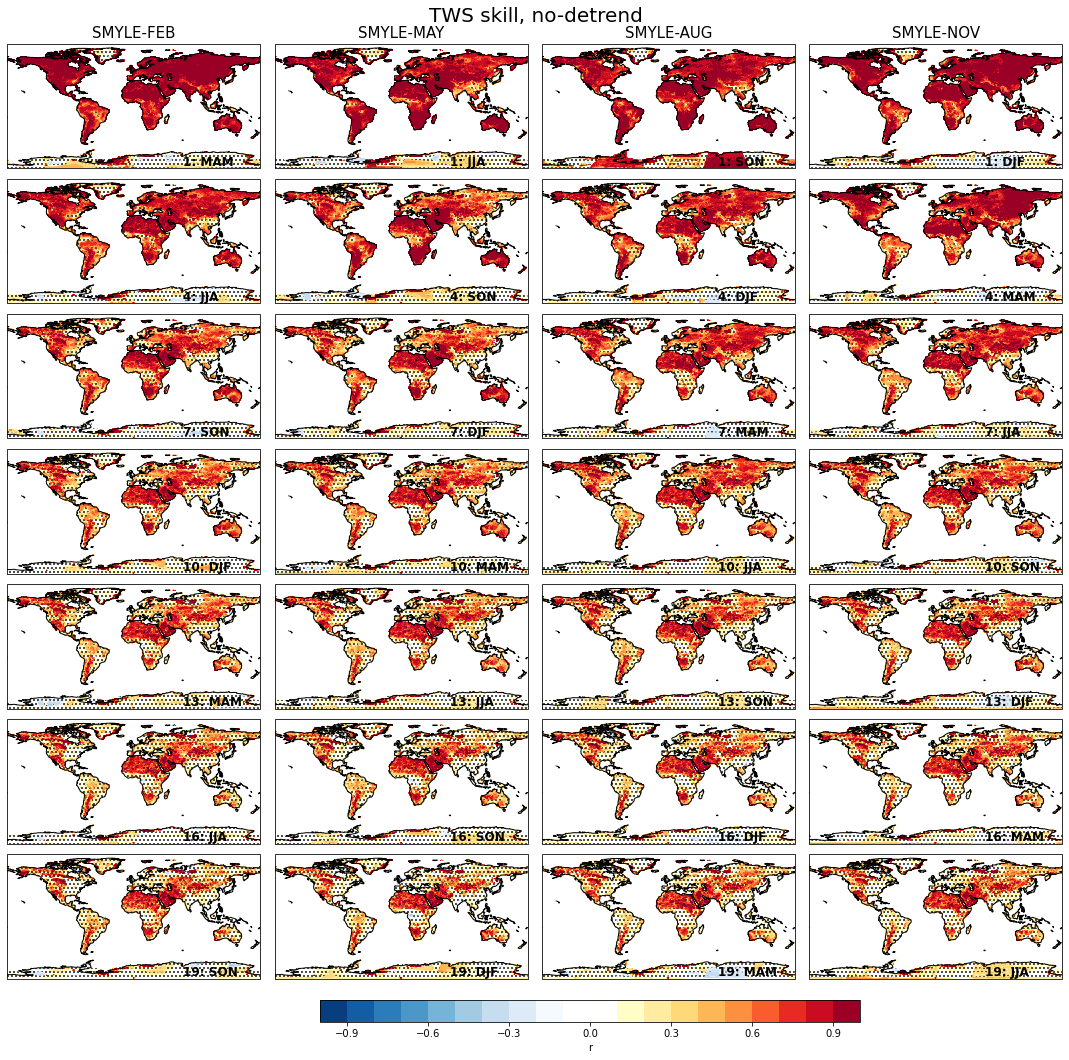

In [49]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(15,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle((field+' skill, no-detrend'),fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal') 
;

### Test Significance Hatching using correlation p-values

CPU times: user 1.17 s, sys: 26.3 ms, total: 1.19 s
Wall time: 1.19 s


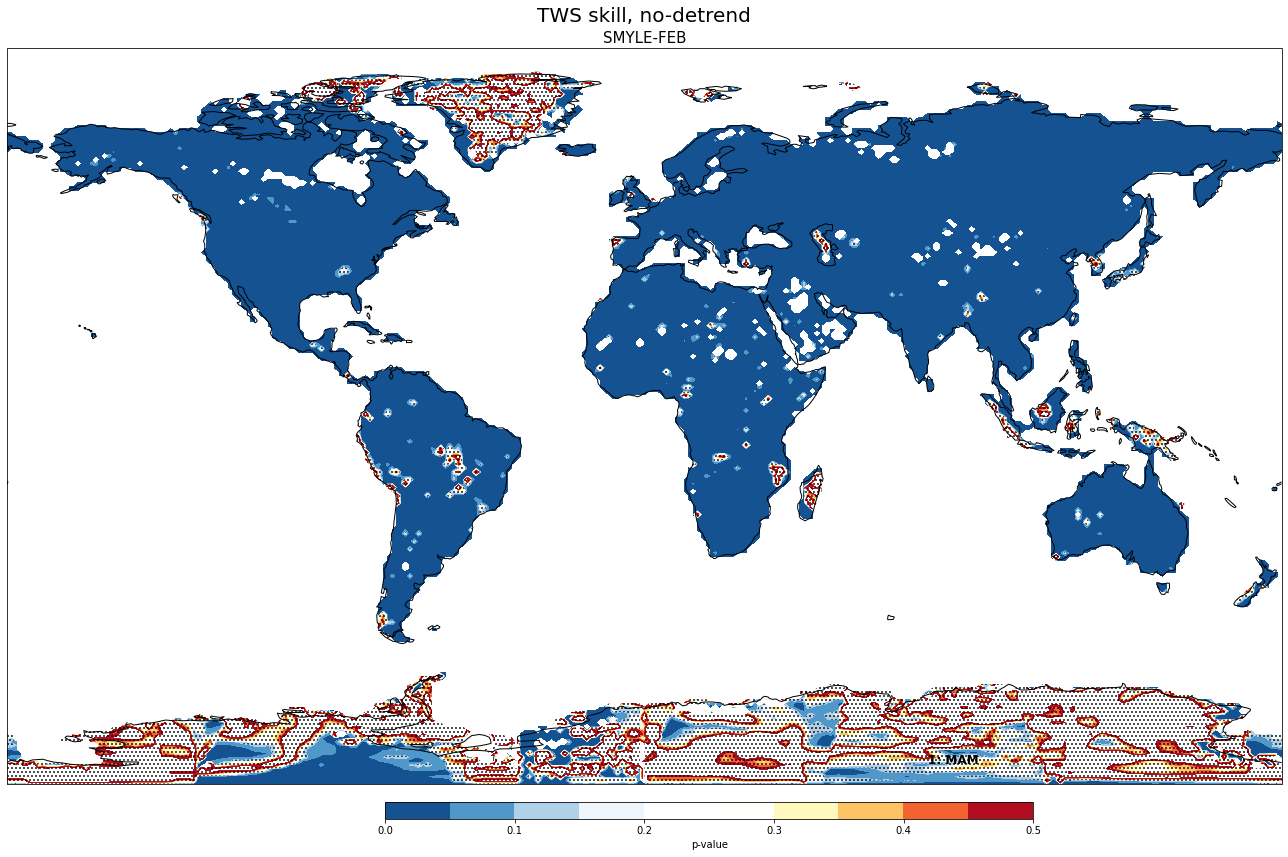

In [50]:
%%time
ci = 0.05
cmin = 0.0
cmax = 0.5
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(18,12))
nrows=1
ncols=1

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = str(i+1)+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.pval.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*4+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...','...'], alpha=0.)
    ldstr = str(i+1) + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(80.,-85,ldstr,fontsize=fsize,fontweight=fweight)



fig.suptitle(field+' skill, no-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='p-value', orientation='horizontal')

### Use Linear Detrending

In [51]:
%%time
smyle11_corr = leadtime_corr_byseas(smyle11_anom[field].isel(Y=slice(0,-2)),smyle11.isel(Y=slice(0,-2)).time,
                                    clm_seas[field],detrend=True)
smyle02_corr = leadtime_corr_byseas(smyle02_anom[field].isel(Y=slice(0,-2)),smyle02.isel(Y=slice(0,-2)).time,
                                    clm_seas[field],detrend=True)
smyle05_corr = leadtime_corr_byseas(smyle05_anom[field].isel(Y=slice(0,-2)),smyle05.isel(Y=slice(0,-2)).time,
                                    clm_seas[field],detrend=True)
smyle08_corr = leadtime_corr_byseas(smyle08_anom[field].isel(Y=slice(0,-2)),smyle08.isel(Y=slice(0,-2)).time,
                                    clm_seas[field],detrend=True)

CPU times: user 53.6 s, sys: 14.7 s, total: 1min 8s
Wall time: 59 s


CPU times: user 1min 18s, sys: 1.77 s, total: 1min 20s
Wall time: 1min 19s


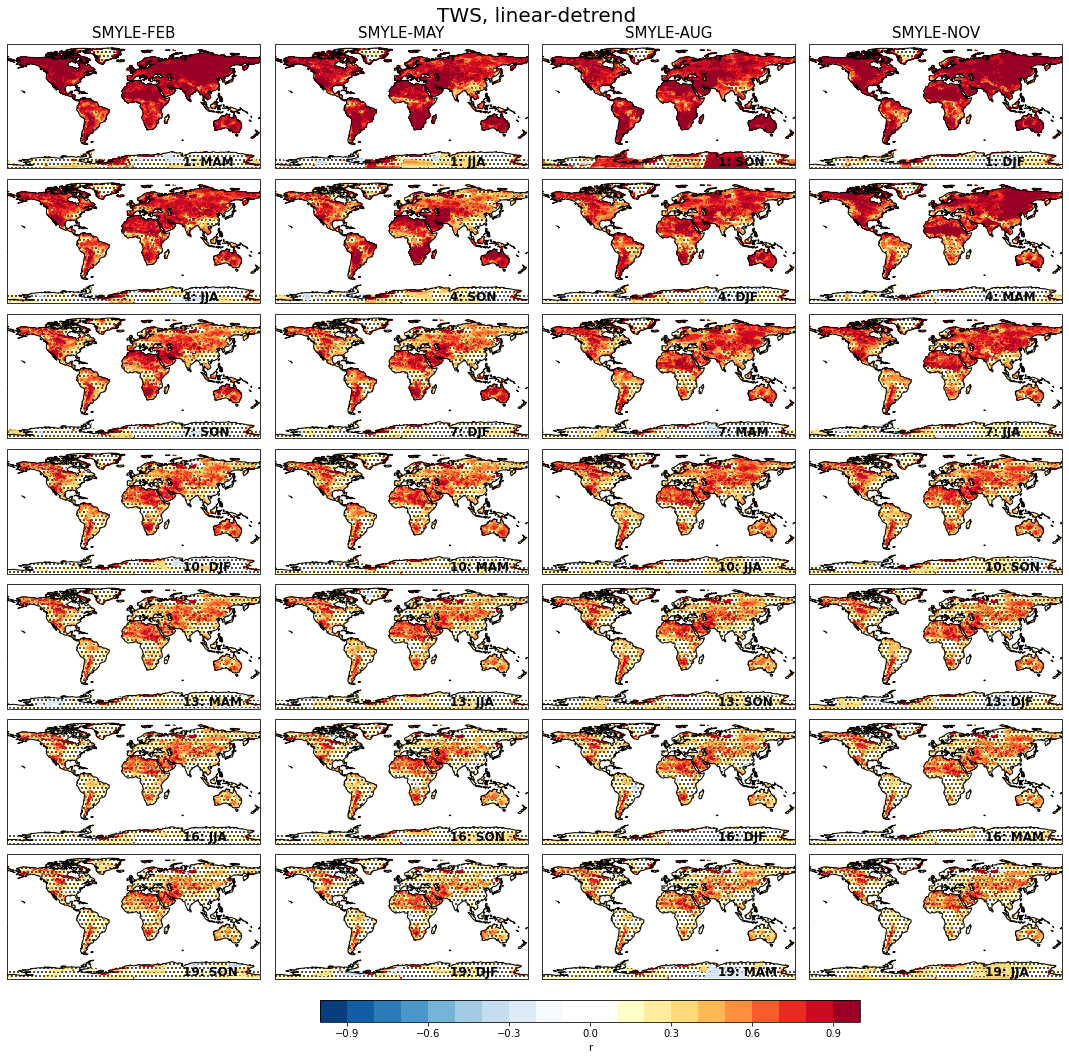

In [52]:
%%time
ci = 0.1
cmin = -1.
cmax = 1.
hatchlevs = [0,0.1,100]
fig = plt.figure(figsize=(15,15))
nrows=7
ncols=4

proj = ccrs.PlateCarree()
#proj = ccrs.Robinson(central_longitude=0)
colstr = ['SMYLE-FEB','SMYLE-MAY','SMYLE-AUG','SMYLE-NOV']
ltime = ['1','4','7','10','13','16','19']
lstr = ''
rstr = ''
fsize=12
fweight='bold'

for i in range(nrows):
    if i>0:
        colstr=['','','','','']
    leadstr = ltime[i]+': '
    ax1,cntr1 = maps.map_contourf_global_subplot(fig, smyle02_corr.corr.isel(L=i), smyle02_corr.lon, smyle02_corr.lat,
                                       ci,cmin,cmax,colstr[0],lstr,rstr,nrows,ncols,i*ncols+1,proj)
    ax1.contourf(smyle02_corr.lon, smyle02_corr.lat,smyle02_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle02_corr.isel(L=i).season.values)
    ax1.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax2,cntr2 = maps.map_contourf_global_subplot(fig, smyle05_corr.corr.isel(L=i), smyle05_corr.lon, smyle05_corr.lat,
                                       ci,cmin,cmax,colstr[1],lstr,rstr,nrows,ncols,i*ncols+2,proj)
    ax2.contourf(smyle05_corr.lon, smyle05_corr.lat,smyle05_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle05_corr.isel(L=i).season.values)
    ax2.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax3,cntr3 = maps.map_contourf_global_subplot(fig, smyle08_corr.corr.isel(L=i), smyle08_corr.lon, smyle08_corr.lat,
                                       ci,cmin,cmax,colstr[2],lstr,rstr,nrows,ncols,i*ncols+3,proj)
    ax3.contourf(smyle08_corr.lon, smyle08_corr.lat,smyle08_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle08_corr.isel(L=i).season.values)
    ax3.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)
    
    ax4,cntr4 = maps.map_contourf_global_subplot(fig, smyle11_corr.corr.isel(L=i), smyle11_corr.lon, smyle11_corr.lat,
                                       ci,cmin,cmax,colstr[3],lstr,rstr,nrows,ncols,i*ncols+4,proj)
    ax4.contourf(smyle11_corr.lon, smyle11_corr.lat,smyle11_corr.pval.isel(L=i), colors='none',levels=hatchlevs,
                 hatches=[None,'...', '...'], alpha=0.)
    ldstr = ltime[i] + ': ' + str(smyle11_corr.isel(L=i).season.values)
    ax4.text(70.,-85,ldstr,fontsize=fsize,fontweight=fweight)


fig.suptitle(field+', linear-detrend',fontsize=20)
fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label='r', orientation='horizontal')
plt.savefig('Fig_'+field+'.png')